In [9]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Parameters
mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 3
which_mode= 'transects'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.3/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.3/')
# input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.3/')
# input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.3/')

input_names= list()
# input_names.append('TKE, ck=0.1')
# input_names.append('TKE, ck=0.3')
input_names.append('TKE+IDEMIX, ck=0.1, jayne (old param)')
input_names.append('TKE+IDEMIX, ck=0.1, jayne (new param)')
input_names.append('TKE+IDEMIX, ck=0.1, nycander (new param)')
input_names.append('TKE+IDEMIX, ck=0.1, stormtide (new param)')
# input_names.append('TKE+IDEMIX, ck=0.3, jayne (new param)')
# input_names.append('TKE+IDEMIX, ck=0.3, nycander (new param)')
# input_names.append('TKE+IDEMIX, ck=0.3, stormtide (new param)')

vname     = 'salt'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
input_transect = list()
input_transect.append([[-30, -30],[-80, 90], 'Transect: -30°W, -80°S-90°N'])

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None

#_____________________________________________________________________________________
ncolumn   = 3 
do_rescale= None
which_dpi = 300
which_res = 0.5
do_ylog   = True

In [11]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac  
if climit   is not None: cinfo['climit']=climit     
if ref_path is not None: cinfo['cref'  ]=0.0    

#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
        
#______________________________________________________________________________________________________    
transects = tpv.analyse_transects(input_transect, which_res='res', res=which_res)

 > found *.pckl file: /work/ollie/pscholz/meshcache_tripyview/core2
 > load  *.pckl file: tripyview_fesom2_core2.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/projects/clidyn/FESOM2/meshes/core2
 > id              = core2
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/3/
1 /home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/3/
2 /home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.1/3/
3 /home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.1/3/


In [12]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    print(ref_path)
    if not vname=='Kv*N2':
        data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, descript=ref_name, do_info=False) 
    else:
        data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname='Kv' , year=ref_year, mon=ref_mon, descript=ref_name , do_info=False)
        data2_ref = tpv.load_data_fesom2(mesh, ref_path, vname='N2' , year=ref_year, mon=ref_mon, descript=ref_name , do_info=False)
        data_ref['Kv'].data = data_ref['Kv'].data * data2_ref['N2'].data
        data_ref  = data.rename(dict({'Kv':'Kv*N2'}))
        data_ref['Kv*N2'].attrs['units'], data_ref['Kv*N2'].attrs['description'], data_ref['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2_ref)
    
    data_ref = tpv.load_transect_fesom2(mesh, data_ref, transects, do_compute=True)

#___LOAD FESOM2 DATA___________________________________________________________________________________
list_transects = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    if not vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript , do_info=False)
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv' , year=year, mon=mon, descript=descript , do_info=False)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2' , year=year, mon=mon, descript=descript , do_info=False)
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2)
        
    data_transects  = tpv.load_transect_fesom2(mesh, data, transects, do_compute=True)
    
    #__________________________________________________________________________________________________    
    if ref_path is not None:
        list_transects.append(tpv.do_transectanomaly(data_transects, data_ref))  
    else:
        list_transects.append(data_transects)  
    del(data, data_transects)
    
if ref_path is not None: del(data_ref)    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and do_clim and  (ref_path is None): 
    clim_vname= vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim          = tpv.load_climatology(mesh, clim_path, clim_vname)
    clim_transect = tpv.load_transect_fesom2(mesh, clim, transects)    
    list_transects.append(clim_transect)

/home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/3/ TKE+IDEMIX, ck=0.1, jayne (old param)
/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/3/ TKE+IDEMIX, ck=0.1, jayne (new param)
/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.1/3/ TKE+IDEMIX, ck=0.1, nycander (new param)
/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.1/3/ TKE+IDEMIX, ck=0.1, stormtide (new param)


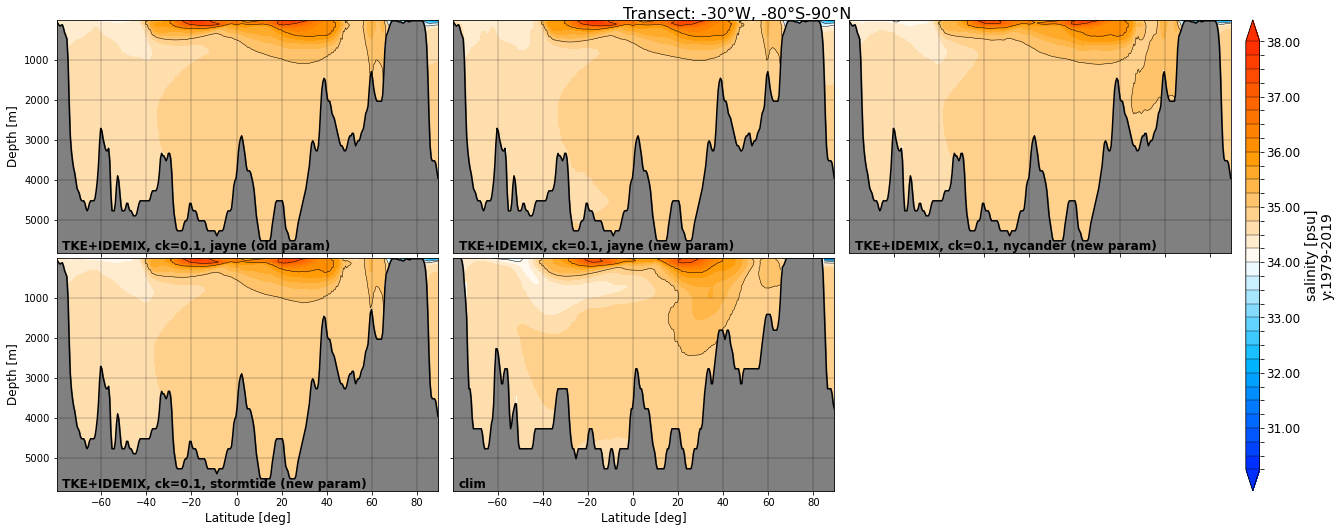

In [13]:
#________________________________________________________________________________________________________
# compute save path
spath  = save_path
sname  = vname
slabel = list_transects[0][0][sname].attrs['str_lsave']
strans = list_transects[0][0][vname].attrs['transect_name'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, strans, slabel) 
nrow   = np.ceil(len(list_transects)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
fig, ax, cbar = tpv.plot_transects(list_transects, transects, cinfo=cinfo, figsize=[ncolumn*7, nrow*3.5], n_rc=[nrow, ncolumn], 
                                pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.08, 0.97,0.95], do_ylog=do_ylog, do_rescale=do_rescale, 
                                do_save = spath, save_dpi=which_dpi)